### 20200422: Downstream analyses of 3D genomic changes in _L. pneumophila_ infected _A. castellanii_
**cmdoret**

In this notebook, I investigate the biological role of regions detected as changing in 3D structure during infection of amoeba by _Legionella pneumophila_. To summarise the context, this is a follow-up on 2 analyses:

1. Genome assembly and annotation of _A. castellanii_ using ONT long reads, Hi-C, Illumina shotgun and RNAseq
2. Pattern detection in Hi-C maps from _A. castellanii_ and quantification of their change during infection.

I use the annotations generated in 1. to investigate potential roles of affected regions in 2.

In [33]:
# Load files and packages
from typing import List, Union, Iterable, Optional
import numpy as np
import pandas as pd
import os
import warnings
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import hicstuff.hicstuff as hcs
import hicstuff.view as hcv
import cooler
import pareidolia.io as pai
import pareidolia.hic_utils as pah
import pareidolia.stats as pas
from cooltools.sample import sample_cooler

os.chdir("/home/cmatthey/Repos/Acastellanii_legionella_infection/")
out = 'data/output/'
indir = 'data/input/'
res = 2000
samples = pd.read_csv('samples.tsv', sep='\t', comment='#')
#infected_bedgraph = pd.read_csv(out + 'all_signals_AT420.bedgraph', sep='\t')
#healthy_bedgraph = pd.read_csv(out + 'all_signals_AT421.bedgraph', sep='\t')
diff_borders = pd.read_csv(out + 'pareidolia/borders_change_infection_time.tsv', sep='\t')
diff_loops = pd.read_csv(out + 'pareidolia/loops_change_infection_time.tsv', sep='\t')
genes = pd.read_csv(indir + 'annotations/c3_annotations/Acanthamoeba_castellanii.annotations.txt', sep='\t')
genes = genes.rename(columns={"Contig": "Chromosome", "Stop": "End"})
# Remove genes which do not have an entrez id
#genes = genes.loc[~np.isnan(genes.entrezgene_id), :]
#genes.entrezgene_id = genes.entrezgene_id.astype(int)


In [34]:
genes.head()

,GeneID,Feature,Chromosome,Start,End,Strand,Name,Product,BUSCO,PFAM,InterPro,EggNog,COG,GO Terms,Secreted,Membrane,Protease,CAZyme,Notes,Translation
0,FUN_000001,CDS,scaffold_1,503,5457,-,NaN,hypothetical protein,NaN,PF00071,IPR001806;IPR020849;IPR027417,NaN,NaN,GO:0016020;GO:0005525;GO:0003924;GO:0007165,NaN,1 (o833-852i),NaN,NaN,NaN,MATKDFKIAIGGPGGVGKSAIVLQFVTGNYVSEYGAYRKQFALGDN...
1,FUN_000002,CDS,scaffold_1,7855,9815,+,NaN,hypothetical protein,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MQLMSTQHHKKRTPEDHRPDLPSSARNLLASSPPARSPRSPDGSPH...
2,FUN_000003,CDS,scaffold_1,10018,10602,-,NaN,hypothetical protein,NaN,PF07258,IPR017920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MWRRPQSVAVGYTGAPKRASLAVGGSGPAVSGRKGDVRFPTLADLR...
3,FUN_000004,CDS,scaffold_1,10748,11427,+,NaN,hypothetical protein,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 (o90-111i),NaN,NaN,NaN,MWKQSSRVAVVARSRAVVPSSSGLRRSAGALLPRRAGAETEPEWKL...
4,FUN_000005,CDS,scaffold_1,11709,30538,-,NaN,hypothetical protein,NaN,PF00076;PF00622;PF00632,IPR000504;IPR000569;IPR001870;IPR003877;IPR012...,NaN,NaN,GO:0004842;GO:0003676;GO:0005515,NaN,2 (o2988-3009i3316-3335o),NaN,NaN,NaN,MGAEEAVHLEGHHSSRSNRPATPQYSAASASGAAPPAPPLRGEAAS...


In [35]:
# Manage cools, merge samples by condition to increase coverage in visualisations
def gather_and_merge_cools(condition: str, merged_out: str):
    cools = (
        samples.loc[samples.condition == condition, 'library']
        .apply(lambda p: f"{out}/cool/{p}.mcool::/resolutions/{res}")
        .tolist()
    )
    cooler.merge_coolers(merged_out, cools, mergebuf=10e8)
    
gather_and_merge_cools('uninfected', "healthy.cool")
gather_and_merge_cools('infected', "infected.cool")


INFO :: Merging:
data/output//cool/AT419.mcool::/resolutions/2000
data/output//cool/AT421.mcool::/resolutions/2000
INFO :: Creating cooler at "healthy.cool::/"
INFO :: Writing chroms
INFO :: Writing bins
INFO :: Writing pixels
INFO :: nnzs: [552433, 1126529]
INFO :: current: [552433, 1126529]
INFO :: Writing indexes
INFO :: Writing info
INFO :: Done
INFO :: Merging:
data/output//cool/AT418.mcool::/resolutions/2000
data/output//cool/AT420.mcool::/resolutions/2000
INFO :: Creating cooler at "infected.cool::/"
INFO :: Writing chroms
INFO :: Writing bins
INFO :: Writing pixels
INFO :: nnzs: [2188053, 1290478]
INFO :: current: [2188053, 1290478]
INFO :: Writing indexes
INFO :: Writing info
INFO :: Done


In [36]:

# Subsample cools to identical coverage between conditions
def subsample_cools(cools: List[str], cpus: int=8, balance: bool=True) -> List['cooler.Cooler']:
    if cpus > 1:
        import multiprocessing as mp
        pool = mp.Pool(cpus)
        my_map = pool.imap_unordered
    else:
        my_map = map
    coolers = pai.get_coolers(cools)
    target = pah.get_min_contacts(coolers)
    sub_cools = ["sub_" + cl for cl in cools]
    for i in range(len(cools)):
        sample_cooler(
            coolers[i],
            sub_cools[i],
            count=target-1,
            exact=False,
            map_func=my_map
        )
    sub_coolers = pai.get_coolers(sub_cools)
    # Balance the subsampled versions
    if balance:
        for clr in sub_coolers:
            cooler.balance_cooler(
                clr,store=True,
                map=my_map,
                mad_max=5,
                chunksize=10000000,
                min_nnz=10,
                max_iters=200,
                ignore_diags=2
            )
    if cpus > 1:
        pool.close()
    return sub_coolers

healthy_cool, infected_cool = subsample_cools(['healthy.cool', 'infected.cool'])

INFO :: Creating cooler at "sub_healthy.cool::/"
INFO :: Writing chroms
INFO :: Writing bins
INFO :: Writing pixels
INFO :: Writing indexes
INFO :: Writing info
INFO :: Done
INFO :: Creating cooler at "sub_infected.cool::/"
INFO :: Writing chroms
INFO :: Writing bins
INFO :: Writing pixels
INFO :: Writing indexes
INFO :: Writing info
INFO :: Done
INFO :: variance is 15059.953436469219
INFO :: variance is 5259.148524382007
INFO :: variance is 1033.5218386415183
INFO :: variance is 839.259225235899
INFO :: variance is 237.09016197579703
INFO :: variance is 179.5109177646491
INFO :: variance is 62.346194316437774
INFO :: variance is 44.48847351670195
INFO :: variance is 17.924859813576266
INFO :: variance is 12.158184825855512
INFO :: variance is 5.494322340395211
INFO :: variance is 3.5787550789553126
INFO :: variance is 1.7663224270731053
INFO :: variance is 1.1175670351155622
INFO :: variance is 0.5890892362071276
INFO :: variance is 0.36584089067647846
INFO :: variance is 0.2022315957

Only regions with p-values below 10e-3 are selected as potential candidates. When replicates will be available, I will use FDR instead of simple p-value.

In [37]:
def filter_patterns(df):
    filt = (df.loc[df.diff_score != 0.0, :]
      .sort_values(abs(df.diff_score))
      .reset_index(drop=True)
   )
    return filt
diff_borders = diff_borders.loc[diff_borders.diff_score != 0.0, :].reset_index(drop=True)
diff_loops = diff_loops.loc[diff_loops.diff_score != 0.0, :].reset_index(drop=True)
diff_borders['pval'] = pas.tvals_to_pvals(diff_borders.diff_score, samples.shape[0])
diff_loops['pval'] = pas.tvals_to_pvals(diff_loops.diff_score, samples.shape[0])
diff_borders.head()

,chrom1,start1,end1,chrom2,start2,end2,bin1,bin2,diff_score,pval
0,scaffold_1,54000,56000,scaffold_1,54000,56000,27.0,27.0,2.889616,0.031516
1,scaffold_1,224000,226000,scaffold_1,224000,226000,112.0,112.0,-1.821815,0.083010
2,scaffold_1,294000,296000,scaffold_1,294000,296000,147.0,147.0,-0.178055,0.435012
3,scaffold_1,478000,480000,scaffold_1,478000,480000,239.0,239.0,-0.808277,0.239040
4,scaffold_1,606000,608000,scaffold_1,606000,608000,303.0,303.0,4.282320,0.011698


In [38]:
len(diff_borders.pval[diff_borders.pval < 0.00001]) / len(diff_borders.pval)

0.0018879798615481435

In [39]:
samples

,library,condition,infection_time,protocol,date
0,AT418,infected,5,hic_arima_dpnII,2020-05
1,AT419,uninfected,0,hic_arima_dpnII,2020-05
2,AT420,infected,5,hic_arima_dpnII,2020-05
3,AT421,uninfected,0,hic_arima_dpnII,2020-05


In [40]:
print(f"Keeping {diff_borders.shape[0]} borders and {diff_loops.shape[0]} loops with detectable change..")

Keeping 1589 borders and 644 loops with detectable change..


In [41]:
def compute_di(mat, max_pix=10):
    """ Computes directionalitin index according to definition from Dixon et al., 2012"""
    
    di = np.zeros(mat.shape[0])
    for i in range(mat.shape[0]):
        before = np.nanmean(mat[i - max_pix: i, i -  max_pix: i])
        after = np.nanmean(mat[i: i + max_pix, i: i +  max_pix])
        expected = (before + after ) / 2
        sign = ((before - after) / np.abs(before - after))
        di[i] = sign * (((after - expected)**2) / expected + ((before - expected)**2) / expected)
    di[:max_pix] = 0
    di[-max_pix:] = 0
    high = np.nanmax(np.abs(di))
    di /= high # Scale to 1
    return di

In [42]:
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (9.0, 6.0)
# Show example regions
def plot_regions(healthy_cool, infected_cool, df, region_id, region_size=100000, blur=0):
    
    def region_lines(ax, s, e):
        """Add lines to mark region of differential contacts"""
        style = {"lw": 0.5, "alpha": 0.6, "c": "g"}
        for i in range(3):
            ax[0, i].axvline(x=s, **style)
            ax[0, i].axvline(x=e, **style)
            ax[0, i].axhline(y=s, **style)
            ax[0, i].axhline(y=e, **style)
            ax[1, i].axvline(x=s, **style)
            ax[1, i].axvline(x=e, **style)
            
    
    def nan_gaussian(U, sigma):
        """Gaussian filter which does not include NAs"""
        import scipy.ndimage as ndi
        V=U.copy()
        V[np.isnan(U)]=0
        VV=ndi.gaussian_filter(V, sigma=sigma)
        W=0*U.copy()+1
        W[np.isnan(U)]=0
        WW=ndi.gaussian_filter(W, sigma=sigma)
        Z=VV/WW   
        return Z
    
    # Extract region of interest
    region = df.iloc[region_id]
    chrom, start, end = region.chrom1, region.start1, region.end1
    pos = (start + end) / 2
    ucsc_query = f'{chrom}:{int(max(0, pos-region_size))}-{int(pos+region_size)}'
    
    # Subset matrix
    healthy_zoom = healthy_cool.matrix(balance=True).fetch(ucsc_query)
    infected_zoom = infected_cool.matrix(balance=True).fetch(ucsc_query)
    infected_zoom[np.isnan(infected_zoom)] = 0.0
    healthy_zoom[np.isnan(healthy_zoom)] = 0.0
    
    # Blur ratio to improve readability
    if blur > 0:
        infected_blur = nan_gaussian(infected_zoom, sigma=blur)
        healthy_blur = nan_gaussian(healthy_zoom, sigma=blur)
    else:
        infected_blur = infected_zoom
        healthy_blur = healthy_zoom

    log_ratio = np.log2(infected_blur / healthy_blur)
    #log_ratio[np.isnan(infected_zoom)] = 0.0
    #log_ratio[np.isnan(healthy_zoom)] = 0.0
    
    # Initialize figure
    fig, ax = plt.subplots(2, 3, sharex=True, sharey=False, gridspec_kw={'height_ratios': [5, 1]})
    
    # Draw lines
    region_size = (end - start) // healthy_cool.binsize
    mid = healthy_zoom.shape[0] // 2
    start_bin, end_bin = mid - region_size, mid + region_size
    region_lines(ax, start_bin, end_bin)
    
    # Make heatmap
    plt.suptitle(f"{chrom}:{start}-{end}")
    ax[0, 0].imshow(np.log2(infected_zoom), cmap="Reds")
    ax[0, 0].set_title("Infected")
    ax[0, 1].imshow(np.log2(healthy_zoom), cmap="Reds")
    ax[0, 1].set_title("Uninfected")
    ax[0, 2].imshow(log_ratio, cmap='bwr', vmin=-2, vmax=2)
    ax[0, 2].set_title("I / U")
    
    # Plot DI
    n = infected_zoom.shape[0]
    infected_di = compute_di(infected_zoom, max_pix=10)
    healthy_di = compute_di(healthy_zoom, max_pix=10)
    
    for i in range(3): ax[1, i].set_ylim(-1, 1, emit=False)
    for i in range(3): ax[1, i].axhline(0, lw=0.5, c='black')
    ax[1, 0].plot(range(n), infected_di)
    ax[1, 1].plot(range(n), healthy_di)
    ax[1, 2].plot(range(n), infected_di - healthy_di)



from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
#show_inter_chr(ot_mat, chrA='chr03', chrB='chr08', var='repeats_prop')
region_size_slider = widgets.IntSlider(min=10000, max=500000, step=2000, value=100000)
blur_slider = widgets.FloatSlider(min=0, max=4, step=0.1, value=0)
pl = interactive(plot_regions, healthy_cool=fixed(healthy_cool),
                 infected_cool=fixed(infected_cool),
                 df=fixed(diff_borders),
                 region_id=range(diff_borders.shape[0]),
                 region_size=region_size_slider,
                 blur=blur_slider
                )
#display(pl)
display(pl)
plt.savefig('test.svg')

interactive(children=(Dropdown(description='region_id', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,…

<Figure size 648x432 with 0 Axes>

In [43]:
%matplotlib inline
set_matplotlib_formats('svg')
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (9.0, 6.0)
# Show example regions


#show_inter_chr(ot_mat, chrA='chr03', chrB='chr08', var='repeats_prop')
pl = interactive(plot_regions, healthy_cool=fixed(healthy_cool),
                 infected_cool=fixed(infected_cool),
                 df=fixed(diff_loops),
                 region_id=range(diff_loops.shape[0]),
                 region_size=region_size_slider,
                 blur=blur_slider
                )
#display(pl)
display(pl)
plt.savefig('test.svg')

interactive(children=(Dropdown(description='region_id', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,…

<Figure size 648x432 with 0 Axes>

Text(0.5, 0, 'Differential score')

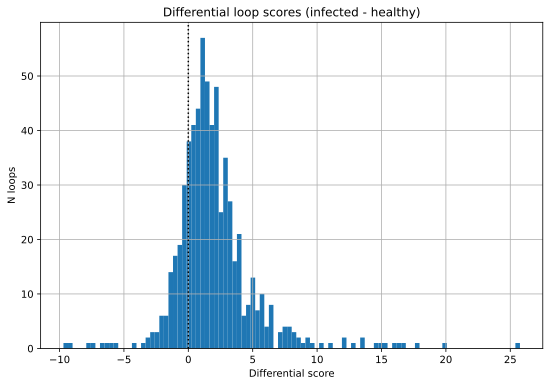

In [56]:
diff_loops.diff_score.hist(bins=100)
plt.axvline(0, linestyle=':', c='black')
plt.title("Differential loop scores (infected - healthy)")
plt.ylabel("N loops")
plt.xlabel("Differential score")

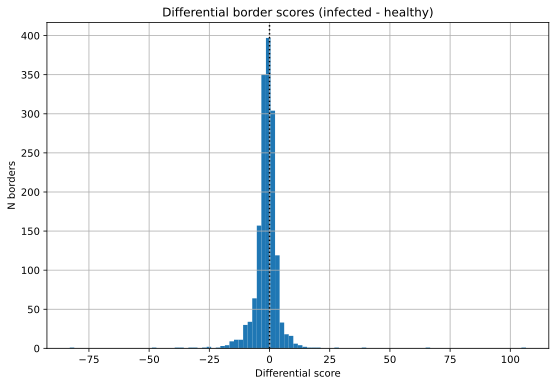

In [57]:
diff_borders.diff_score.hist(bins=100)
plt.title("Differential border scores (infected - healthy)")
plt.ylabel("N borders")
plt.xlabel("Differential score")
plt.axvline(0, linestyle=':', c='black')

All genes that overlap regions of differential contacts are then selected. This may not be optimal because genes may be separated from their enhancer element without being affected directly. This can happen if a domain boundary moves into the sequence between gene and enhancer.

The enrichment of GO terms (annotations) within regions with altered chromatin conformation is then tested to check for specific pathways or funcions.

In [58]:
genes.head()


,GeneID,Feature,Chromosome,Start,End,Strand,Name,Product,BUSCO,PFAM,InterPro,EggNog,COG,GO Terms,Secreted,Membrane,Protease,CAZyme,Notes,Translation
0,FUN_000001,CDS,scaffold_1,503,5457,-,NaN,hypothetical protein,NaN,PF00071,IPR001806;IPR020849;IPR027417,NaN,NaN,GO:0016020;GO:0005525;GO:0003924;GO:0007165,NaN,1 (o833-852i),NaN,NaN,NaN,MATKDFKIAIGGPGGVGKSAIVLQFVTGNYVSEYGAYRKQFALGDN...
1,FUN_000002,CDS,scaffold_1,7855,9815,+,NaN,hypothetical protein,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MQLMSTQHHKKRTPEDHRPDLPSSARNLLASSPPARSPRSPDGSPH...
2,FUN_000003,CDS,scaffold_1,10018,10602,-,NaN,hypothetical protein,NaN,PF07258,IPR017920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MWRRPQSVAVGYTGAPKRASLAVGGSGPAVSGRKGDVRFPTLADLR...
3,FUN_000004,CDS,scaffold_1,10748,11427,+,NaN,hypothetical protein,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1 (o90-111i),NaN,NaN,NaN,MWKQSSRVAVVARSRAVVPSSSGLRRSAGALLPRRAGAETEPEWKL...
4,FUN_000005,CDS,scaffold_1,11709,30538,-,NaN,hypothetical protein,NaN,PF00076;PF00622;PF00632,IPR000504;IPR000569;IPR001870;IPR003877;IPR012...,NaN,NaN,GO:0004842;GO:0003676;GO:0005515,NaN,2 (o2988-3009i3316-3335o),NaN,NaN,NaN,MGAEEAVHLEGHHSSRSNRPATPQYSAASASGAAPPAPPLRGEAAS...


In [26]:
import pyranges as pr
genes_pr = pr.PyRanges(genes)

In [27]:
diff_borders_pr = pr.PyRanges(
    diff_borders
    .loc[:, ["chrom1", "start1", "end1", "diff_score"]]
    .rename(columns={"chrom1": "Chromosome", "start1": "Start", "end1": "End", "diff_score": "Score"})
)
diff_loops_pr = pr.PyRanges(
    pd.concat([
        (diff_loops
            .loc[:, ["chrom1", "start1", "end1", "diff_score"]]
            .rename(columns={"chrom1": "Chromosome", "start1": "Start", "end1": "End"})),
        (diff_loops
        .loc[:, ["chrom2", "start2", "end2", "diff_score"]]
        .rename(columns={"chrom2": "Chromosome", "start2": "Start", "end2": "End"}))
    ])
)

In [28]:
# Overlap with annotations
diff_borders_genes = genes_pr.overlap(diff_borders_pr).df
diff_loops_genes = genes_pr.overlap(diff_loops_pr).df

Extract known proteins, excluding tRNA genes for visual inspection

In [29]:
def gene_stats(df, name):
    is_known = df.Product[df.Product != 'hypothetical protein']
    known = len(is_known[is_known])
    is_trna = df.Product.str.contains('tRNA-')
    trna = len(is_trna[is_trna])
    print(
        f"There are {df.shape[0]} {name}, of which {known} have known functions, "
        f"including {trna} tRNAs."
    )

In [30]:
known_loops_genes = diff_loops_genes.loc[(~diff_loops_genes.Product.str.contains('tRNA-')) & (diff_loops_genes.Product != 'hypothetical protein'), :]

In [31]:
known_borders_genes = diff_borders_genes.loc[(~diff_borders_genes.Product.str.contains('tRNA-')) & (diff_borders_genes.Product != 'hypothetical protein'), :]

In [32]:

gene_stats(genes, "genes in the genome")


KeyError: "None of [Index(['Actin-1', 'ADP-ribosylation factor-like protein 8',\n       'AP-2 complex subunit sigma', 'Glycogen synthase kinase-3 beta',\n       'Ras- protein Rab-11A', 'T-complex protein 1 subunit delta',\n       'Golgi to ER traffic- protein',\n       'Putative tRNA (cytidine(32)/guanosine(34)-2'-O)-methyltransferase',\n       'ribosomal protein S14, S11', 'Proteasome subunit beta type-3',\n       ...\n       'tRNA-Leu', 'tRNA-Leu', 'tRNA-Ile', 'tRNA-Glu', 'tRNA-Lys', 'tRNA-Gln',\n       'tRNA-Met', 'tRNA-Ala', 'tRNA-Pro', 'tRNA-Asp'],\n      dtype='object', length=735)] are in the [index]"

In [24]:
gene_stats(diff_loops_genes, 'infection dependent loop genes')

KeyError: "None of [Index(['tRNA-Gly',\n       'Putative tRNA (cytidine(32)/guanosine(34)-2'-O)-methyltransferase',\n       'ribosomal protein S14, S11', 'Proteasome subunit beta type-3',\n       'tRNA-Gly', 'Actin-1', 'tRNA-Ser', 'tRNA-Gly', 'tRNA-Ser', 'tRNA-Ser',\n       'tRNA-Arg', 'Pre-mRNA-splicing factor ATP-dependent RNA helicase PRP16',\n       'Alpha-aminoadipic semialdehyde dehydrogenase',\n       'Ubiquitin-60S ribosomal protein L40', 'tRNA-Gly',\n       'Rho GTPase protein rac1', 'T-complex protein 1 subunit zeta',\n       'tRNA-Gly', 'ADP-ribosylation factor 1', 'tRNA-Pro', 'tRNA-Pro',\n       'tRNA-Pro', 'Ras- C3 botulinum toxin substrate 3',\n       'translation elongation factor EF-1 alpha',\n       'DNA-binding transcription factor rap1', 'Peroxiredoxin-2', 'Actin-1'],\n      dtype='object')] are in the [index]"

In [139]:
gene_stats(diff_borders_genes, 'infection dependent border genes')

There are 3063 infection dependent border genes, of which 125 have known functions, including 63 tRNAs.


In [148]:
print(known_borders_genes.loc[:, ["GeneID", "Feature", "Chromosome", "Start", "End", "Strand", "Name", "Product",]].to_markdown())

|      | GeneID     | Feature   | Chromosome   |   Start |     End | Strand   | Name        | Product                                                                           |
|-----:|:-----------|:----------|:-------------|--------:|--------:|:---------|:------------|:----------------------------------------------------------------------------------|
|   15 | FUN_000207 | CDS       | scaffold_1   |  616228 |  618206 | +        | GSK3B       | Glycogen synthase kinase-3 beta                                                   |
|  126 | FUN_000336 | CDS       | scaffold_1   | 1007079 | 1008861 | -        | FTSJ1       | Putative tRNA (cytidine(32)/guanosine(34)-2'-O)-methyltransferase                 |
|  136 | FUN_000422 | CDS       | scaffold_1   | 1323317 | 1324222 | -        | AP1S2       | AP-1 complex subunit sigma-2                                                      |
|  151 | FUN_000568 | CDS       | scaffold_1   | 1720411 | 1721486 | -        | RAB2A_1     | Ras- protein Rab

In [ ]:
# Compute GO enrichment


In [ ]:
exp_all_genes = {x: GeneID2nt_mus[x] for x in genes.entrezgene_id if x in GeneID2nt_mus.keys()}
exp_diff_genes = {x: GeneID2nt_mus[x] for x in genes_diff.entrezgene_id if x in GeneID2nt_mus.keys()}

In [ ]:
exp_diff_genes

In [ ]:
# Build GO enrichment analysis object

goeaobj = GOEnrichmentStudyNS(
        exp_all_genes.keys(), # List of mouse protein-coding genes
        ns2assoc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method

In [ ]:
# Run gene ontology enrichment analysis
# 'p_' means "pvalue". 'fdr_bh' is the multipletest method we are currently using.
geneids_study = exp_diff_genes.keys()
goea_results_all = goeaobj.run_study(geneids_study)
goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]

When running the analysis with a stringent threshold of pvalue < 10-4, I get no enriched biological process or molecular function, but only cellular component "Nucleosome" with genes Tnp2, Prm1, Prm2 and Prm3.

When running the analysis with less stringent filter pvalue < 10-3, I get enrichment for biological processes keratinization, keratinocyte differentiation and peptide cross linking. This is due to a group of several Sprr genes in the region at chr3:92Mb-94Mb

In [ ]:
%matplotlib notebook
# Save and visualize results
gene2sym = { k: v.Symbol for k, v in exp_diff_genes.items()}
goeaobj.wr_txt(out+"go_enrichment.txt", goea_results_sig)
plot_results(out+"mouse_salmonella_GO_enriched_{NS}.png",
             goea_results_sig,
             id2symbol=gene2sym,
             study_items=6)


In [ ]:
img=mpimg.imread(out+"mouse_salmonella_GO_enriched_BP.png")
plt.figure()
plt.imshow(img)
plt.show()

In [ ]:
img=mpimg.imread(out+"mouse_salmonella_GO_enriched_CC.png")
plt.figure()
plt.imshow(img)
plt.show()

In [ ]:
img=mpimg.imread(out+"mouse_salmonella_GO_enriched_MF.png")
plt.figure()
plt.imshow(img)
plt.show()